In [69]:
import numpy
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline
import numpy as np

In [70]:
df = pd.read_csv("out_without_nan_mood_normalised_extra_temp_train.csv")
df['mood_mean_TARGET'] = df['mood_mean_TARGET'].astype(float)
df = pd.concat([df,pd.get_dummies(df['id'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['weekDay'],prefix="day_")],axis=1)
df = df.drop(['weekDay_time_5','day_time_5','weekDay_time_4','day_time_4','weekDay_time_3','day_time_3','weekDay_time_2','day_time_2','weekDay_time_1','day_time_1','weekDay_time_5','mood_mean_time_1','circumplex.valence_mean_time_1'],axis=1)
df = df.fillna(0)
df = df.loc[:, (df != 0).any(axis=0)]

Lets remove highly correlated features

In [58]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr) and corr_matrix.columns[i] != "mood_mean_TARGET" and corr_matrix.columns[j] != "mood_mean_TARGET":
                
                colnameI = corr_matrix.columns[i]
                colnameJ = corr_matrix.columns[j]
                if abs(corr_matrix.mood_mean_TARGET[colnameI]) > abs(corr_matrix.mood_mean_TARGET[colnameJ]):
                    colname = colnameJ
                else:
                    colname = colnameI
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    
    return(dataset)
newDF =df
#correlation(newDF,0.7)
print(newDF.columns.values)

['id' 'date' 'activity_mean' 'circumplex.arousal_mean'
 'circumplex.valence_mean' 'mood_mean' 'appCat.builtin_sum'
 'appCat.communication_sum' 'appCat.entertainment_sum'
 'appCat.finance_sum' 'appCat.game_sum' 'appCat.office_sum'
 'appCat.other_sum' 'appCat.social_sum' 'appCat.travel_sum'
 'appCat.unknown_sum' 'appCat.utilities_sum' 'appCat.weather_sum'
 'call_sum' 'screen_sum' 'sms_sum' 'day' 'weekDay' 'activity_mean_time_1'
 'circumplex.arousal_mean_time_1' 'appCat.builtin_sum_time_1'
 'appCat.communication_sum_time_1' 'appCat.entertainment_sum_time_1'
 'appCat.finance_sum_time_1' 'appCat.game_sum_time_1'
 'appCat.office_sum_time_1' 'appCat.other_sum_time_1'
 'appCat.social_sum_time_1' 'appCat.travel_sum_time_1'
 'appCat.unknown_sum_time_1' 'appCat.utilities_sum_time_1'
 'appCat.weather_sum_time_1' 'call_sum_time_1' 'screen_sum_time_1'
 'sms_sum_time_1' 'activity_mean_time_2' 'circumplex.arousal_mean_time_2'
 'circumplex.valence_mean_time_2' 'mood_mean_time_2'
 'appCat.builtin_sum_ti

In [73]:
corr=df.corr()
goodColumns= corr[abs(corr['mood_mean_TARGET'])>0.25]['mood_mean_TARGET'].sort_values()
goodColumns = goodColumns.drop(['mood_mean_TARGET'])

usedColumns = goodColumns.keys()



In [75]:
usedColumns


Index(['numberOfTimesSeenMood5Days_5', 'numberOfTimesSeenMood5Days_6',
       'numberOfTimesSeenMood5Days_4', 'mood_mean', 'mood_mean_time_3',
       'mood_mean_time_4', 'mood_mean_time_2', 'mood_mean_time_5'],
      dtype='object')

In [76]:
notRelevantAll=df.drop(['id','date'],axis=1).dropna()
goldY= notRelevantAll['mood_mean_TARGET']
relevant = notRelevantAll.drop(['mood_mean_TARGET'],axis=1)


In [80]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(len(usedColumns), input_dim=len(usedColumns), kernel_initializer='normal', activation='relu'))
    # The Hidden Layers :
    #model.add(Dense(len(usedColumns)*2, kernel_initializer='normal',activation='relu'))

    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [81]:
# fix random seed for reproducibility
seed = 99
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [ ]:
scoring = {'R2': 'r2',
           'Mean squared Error': 'neg_mean_squared_error',
           'Explained variance': 'explained_variance'}

scores = cross_validate(estimator, relevant[usedColumns], goldY, cv=7,scoring=scoring)
print("R2: %0.2f (+/- %0.2f)" % (scores['test_R2'].mean(), scores['test_R2'].std() * 2))
print("MSE: %0.2f (+/- %0.2f)" % (scores['test_Mean squared Error'].mean(), scores['test_Mean squared Error'].std() * 2))
print("EXPLAINED VARIANCE: %0.2f (+/- %0.2f)" % (scores['test_Explained variance'].mean(), scores['test_Explained variance'].std() * 2))


MAE
0.44135347953058557
MSE
0.35865445484439834
RMSE
0.598877662669429
R2
0.3549722849890866


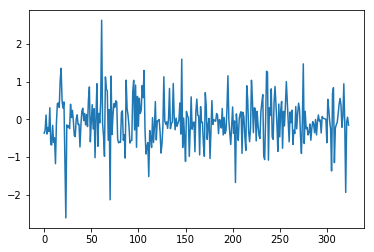

In [84]:
estimator.fit(relevant[usedColumns], goldY)
dfTest = pd.read_csv("out_without_nan_mood_normalised_extra_temp_test.csv")
dfTest['mood_mean_TARGET'] = dfTest['mood_mean_TARGET'].astype(float)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['id'])],axis=1)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['weekDay'],prefix="day_")],axis=1)
dfTest = dfTest.fillna(0)
y_pred = estimator.predict(dfTest[usedColumns])
print("MAE")
print(metrics.mean_absolute_error(dfTest['mood_mean_TARGET'],y_pred))
print("MSE")
print(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred))
print("RMSE")
print(np.sqrt(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred)))
print("R2")
print(metrics.r2_score(dfTest['mood_mean_TARGET'],y_pred))

import matplotlib.pyplot as plt
plt.plot(y_pred-dfTest['mood_mean_TARGET'])
plt.show()


allTogether = pd.concat([dfTest['mood_mean_TARGET'],dfTest[usedColumns]],axis=1)
allTogether['y_pred'] = y_pred
allTogether.to_csv("pred.csv")